# ===========================================================
# Checking whether skills (individual performance) is correlated or caused given influence 
# ===========================================================

## Goals:
####   1. Compute individual performance (unweighted and hardness weighted)
####   2. Compute corr and causality of them with given influence by others to every member

#### Last update: 16 Dec 2019

# Imports

In [920]:
from __future__ import division, print_function, absolute_import, unicode_literals

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import imp
import networkx as nx
from collections import defaultdict
import sys
sys.path.insert(0, '../src/')
%matplotlib inline

import text_processor
import pogs_jeopardy_log_lib
import broadcast_network_extraction
import utils
from mytimer import Timer

In [921]:
def reload():
    imp.reload(pogs_jeopardy_log_lib)
    imp.reload(text_processor)
    imp.reload(utils)

In [922]:
reload()

# Parameters

In [923]:
directory = '/home/omid/Datasets/Jeopardy/'

# Helper functions

In [924]:
def get_normalized_influence_on_others(A: np.ndarray, index: int) -> float:
    A = np.array(A)
    return sum(
        A[[i for i in range(len(A))
           if i != index], index])

#     A[0, 0] = 0
#     A[1, 1] = 0
#     A[2, 2] = 0
#     A[3, 3] = 0
#     A = utils.make_matrix_row_stochastic(A)
#     eigen_values, eigen_vectors = np.linalg.eig(A.T)
#     largest_eigen_value_index = np.where(eigen_values > 0.99)[0][0]
#     stationary_distribution = eigen_vectors[:, largest_eigen_value_index]
#     stationary_distribution /= np.sum(stationary_distribution)
#     return np.real(stationary_distribution[index])

# Loading teams' logs

In [925]:
data = utils.load_it(directory+'Teams_logs.pk')

In [926]:
len(data)

49

In [932]:
hardness_weights = {
    pogs_jeopardy_log_lib.Level.EASY: 1,
    pogs_jeopardy_log_lib.Level.MEDIUM: 2,
    pogs_jeopardy_log_lib.Level.HARD: 3}
minimum_number_of_questions_to_answer = 44

questions = data[37].game_info.questions
individual_performances = {}
for team_id, team_log in data.items():
    individual_performances[team_id] = defaultdict(
        lambda: {'#correct': 0,
                 '#questions': 0,
                 '#hardness_weighted_correct': 0,
                 '#hardness_weighted_questions': 0})
    for qid, team_answers in team_log.individual_answers_chosen.items():
        hardness_weight = hardness_weights[questions[qid].level]
        for member in team_log.members:
            if member in team_answers:
                individual_performances[team_id][member]['#questions'] += 1
                individual_performances[team_id][member]['#hardness_weighted_questions'] += hardness_weight
                if questions[qid].answer == team_answers[member]:
                    individual_performances[team_id][member]['#correct'] += 1
                    individual_performances[team_id][member]['#hardness_weighted_correct'] += hardness_weight
individual_performance_rates = defaultdict(dict)
for team_id, team_log in data.items():
    for member in team_log.members:
        if individual_performances[team_id][member]['#questions'] >= minimum_number_of_questions_to_answer:
            correct_rate = individual_performances[team_id][member]['#correct'] / individual_performances[team_id][member]['#questions']
            hardness_weighted_correct_rate = individual_performances[team_id][member]['#hardness_weighted_correct'] / individual_performances[team_id][member]['#hardness_weighted_questions']
            individual_performance_rates[team_id][member] = {
                'correct_rate': correct_rate,
                'hardness_weighted_correct_rate': hardness_weighted_correct_rate}

In [933]:
len(individual_performance_rates)

31

In [941]:
amount_of_appraise_by_others_vector = []
inidividual_performance_vector = []
inidividual_weighted_performance_vector = []
for team_id, team_log in data.items():
    if team_id in individual_performance_rates:
        if len(team_log.member_influences) < 1 or np.sum(team_log.member_influences_from_data[-1]) != 16:
            continue
        influence_matrix = utils.make_matrix_row_stochastic(
            np.matrix(team_log.member_influences[-1]) / 100)
#         if len(team_log.member_influences) < 2 or np.sum(team_log.member_influences_from_data[-1]) != 16 or np.sum(team_log.member_influences_from_data[-2]) != 16:
#             continue
#         influence_matrix = utils.make_matrix_row_stochastic(
#             (np.matrix(team_log.member_influences[-1]) + np.matrix(team_log.member_influences[-2])) / 200)
        for index, member in enumerate(team_log.members):
            if member in individual_performance_rates[team_id]:
                amount_of_appraise_by_others_vector.append(
                    get_normalized_influence_on_others(
                        influence_matrix, index))
                inidividual_performance_vector.append(
                    individual_performance_rates[team_id][member]['correct_rate'])
                inidividual_weighted_performance_vector.append(
                    individual_performance_rates[team_id][member]['hardness_weighted_correct_rate'])
amount_of_appraise_by_others_vector = np.array(amount_of_appraise_by_others_vector)
inidividual_performance_vector = np.array(inidividual_performance_vector)
inidividual_weighted_performance_vector = np.array(inidividual_weighted_performance_vector)

In [942]:
len(amount_of_appraise_by_others_vector)

116

r-val: -0.18720556825543863
p-val: 0.044192842577459146 	yay!!!!


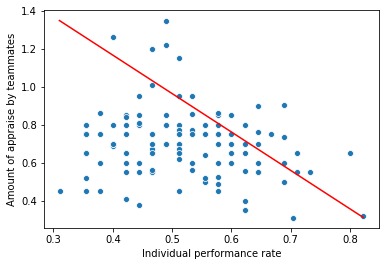


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4349  , p=0.5109  , df_denom=112, df_num=1
ssr based chi2 test:   chi2=0.4466  , p=0.5040  , df=1
likelihood ratio test: chi2=0.4457  , p=0.5044  , df=1
parameter F test:         F=0.4349  , p=0.5109  , df_denom=112, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1837  , p=0.8324  , df_denom=109, df_num=2
ssr based chi2 test:   chi2=0.3843  , p=0.8252  , df=2
likelihood ratio test: chi2=0.3836  , p=0.8255  , df=2
parameter F test:         F=0.1837  , p=0.8324  , df_denom=109, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0829  , p=0.9692  , df_denom=106, df_num=3
ssr based chi2 test:   chi2=0.2650  , p=0.9665  , df=3
likelihood ratio test: chi2=0.2647  , p=0.9665  , df=3
parameter F test:         F=0.0829  , p=0.9692  , df_denom=106, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4722  , p=0.7560  

{'causality': {1: ({'lrtest': (0.4457339865338099, 0.5043678091565604, 1),
    'params_ftest': (0.43494851774412635, 0.5109245434158095, 112.0, 1),
    'ssr_chi2test': (0.4465989244694111, 0.5039545116279669, 1),
    'ssr_ftest': (0.4349485177441221, 0.5109245434158216, 112.0, 1)},
    array([[0., 1., 0.]])]),
  2: ({'lrtest': (0.3836375450117657, 0.8254564503410993, 2),
    'params_ftest': (0.18371461710839584, 0.8324303964850461, 109.0, 2),
    'ssr_chi2test': (0.3842837862450711, 0.8251897714308923, 2),
    'ssr_ftest': (0.18371461710838927, 0.8324303964850511, 109.0, 2)},
    array([[0., 0., 1., 0., 0.],
           [0., 0., 0., 1., 0.]])]),
  3: ({'lrtest': (0.264679936384141, 0.966528327846882, 3),
    'params_ftest': (0.08285827964837775, 0.9692371516486697, 106.0, 3),
    'ssr_chi2test': (0.2649901584981039, 0.9664725370790233, 3),
    'ssr_ftest': (0.08285827964837468, 0.9692371516486719, 106.0, 3)},
    array([[0., 0., 0., 1., 0., 0., 0.],
           [0., 0., 0., 0., 1., 0., 0

In [943]:
utils.compute_relationship(
    amount_of_appraise_by_others_vector,
    inidividual_performance_vector,
    'Amount of appraise by teammates',
    'Individual performance rate',
    fname='appraise_vs_individualperformance')

r-val: -0.19750765841285636
p-val: 0.033572696068435375 	yay!!!!


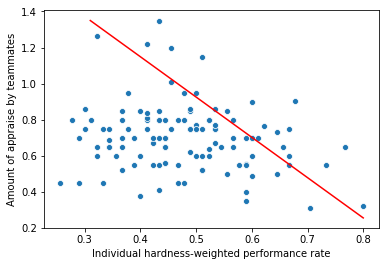


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3251  , p=0.5697  , df_denom=112, df_num=1
ssr based chi2 test:   chi2=0.3338  , p=0.5634  , df=1
likelihood ratio test: chi2=0.3333  , p=0.5637  , df=1
parameter F test:         F=0.3251  , p=0.5697  , df_denom=112, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1792  , p=0.8362  , df_denom=109, df_num=2
ssr based chi2 test:   chi2=0.3749  , p=0.8291  , df=2
likelihood ratio test: chi2=0.3743  , p=0.8293  , df=2
parameter F test:         F=0.1792  , p=0.8362  , df_denom=109, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0628  , p=0.9793  , df_denom=106, df_num=3
ssr based chi2 test:   chi2=0.2009  , p=0.9774  , df=3
likelihood ratio test: chi2=0.2008  , p=0.9775  , df=3
parameter F test:         F=0.0628  , p=0.9793  , df_denom=106, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2506  , p=0.9087  

{'causality': {1: ({'lrtest': (0.33331088559282307, 0.5637159918302357, 1),
    'params_ftest': (0.3250866998554921, 0.5697086464924088, 112.0, 1),
    'ssr_chi2test': (0.3337943793158965, 0.5634333159703946, 1),
    'ssr_ftest': (0.3250866998554818, 0.5697086464924161, 112.0, 1)},
    array([[0., 1., 0.]])]),
  2: ({'lrtest': (0.37427932653054086, 0.829327901653939, 2),
    'params_ftest': (0.17922583513499385, 0.8361629377299042, 109.0, 2),
    'ssr_chi2test': (0.374894407438323, 0.8290728889900049, 2),
    'ssr_ftest': (0.17922583513498774, 0.8361629377299094, 109.0, 2)},
    array([[0., 0., 1., 0., 0.],
           [0., 0., 0., 1., 0.]])]),
  3: ({'lrtest': (0.20075479438713728, 0.9774673562408576, 3),
    'params_ftest': (0.06282867947160238, 0.9793131360414475, 106.0, 3),
    'ssr_chi2test': (0.2009332296308754, 0.9774385021483123, 3),
    'ssr_ftest': (0.06282867947160115, 0.9793131360414475, 106.0, 3)},
    array([[0., 0., 0., 1., 0., 0., 0.],
           [0., 0., 0., 0., 1., 0.,

In [944]:
utils.compute_relationship(
    amount_of_appraise_by_others_vector,
    inidividual_weighted_performance_vector,
    'Amount of appraise by teammates',
    'Individual hardness-weighted performance rate',
    fname='appraise_vs_individualwperformance')

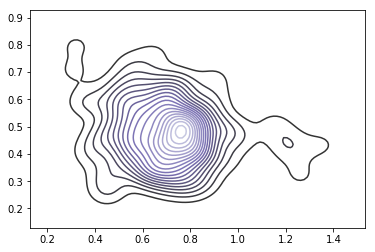

In [274]:
sns.kdeplot(
    amount_of_appraise_by_others_vector,
    inidividual_weighted_performance_vector,
    n_levels=20, cmap="Purples_d")

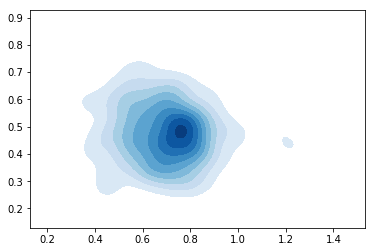

In [275]:
sns.kdeplot(
    amount_of_appraise_by_others_vector,
    inidividual_weighted_performance_vector,
    cmap="Blues", shade=True, shade_lowest=False)

In [276]:
dt = pd.DataFrame(
    {'Appraise_by_others': amount_of_appraise_by_others_vector,
     'Inidividual_weighted_performance': inidividual_weighted_performance_vector})

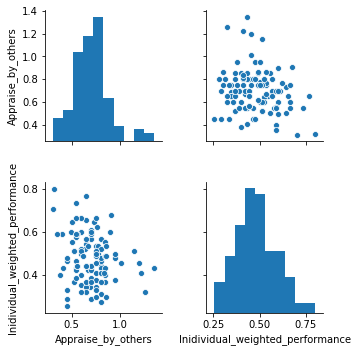

In [277]:
sns.pairplot(dt);

# Relationship of network based features with the amount of appraisals by others

In [913]:
# networks = utils.load_it(directory+'Teams_networks.pk')
networks = utils.load_it(directory+'Teams_networks_sum.pk')

In [914]:
amount_of_appraise_by_others_vector = []
emotion_dominance_vector_out = []
reply_duration_vector_out = []
emotion_arousal_vector_out = []
emotion_valence_vector_out = []
sentiment_vector_out = []
emotion_dominance_vector_in = []
reply_duration_vector_in = []
emotion_arousal_vector_in = []
emotion_valence_vector_in = []
sentiment_vector_in = []
for team_id, team_log in data.items():
    if len(team_log.member_influences) < 1: #or np.sum(team_log.member_influences_from_data[-1]) != 16:
        print('ignored.')
        continue
    for i in range(len(team_log.member_influences)):
        influence_matrix = utils.make_matrix_row_stochastic(
            np.matrix(team_log.member_influences[i]) / 100)
        for index, member in enumerate(team_log.members):
            if member in individual_performance_rates[team_id]:
                amount_of_appraise_by_others_vector.append(
                    get_normalized_influence_on_others(
                        influence_matrix, index))

                reply_duration_vector_in.append(
                    networks[team_id][i]['reply_duration'].in_degree(member, weight='weight'))
                reply_duration_vector_out.append(
                    networks[team_id][i]['reply_duration'].out_degree(member, weight='weight'))
                
                emotion_dominance_vector_in.append(
                    networks[team_id][i]['emotion_dominance'].in_degree(member, weight='weight'))
                emotion_dominance_vector_out.append(
                    networks[team_id][i]['emotion_dominance'].out_degree(member, weight='weight'))
                
                emotion_arousal_vector_in.append(
                    networks[team_id][i]['emotion_arousal'].in_degree(member, weight='weight'))
                emotion_arousal_vector_out.append(
                    networks[team_id][i]['emotion_arousal'].out_degree(member, weight='weight'))
                
                sentiment_vector_in.append(
                    networks[team_id][i]['sentiment'].in_degree(member, weight='weight'))
                sentiment_vector_out.append(
                    networks[team_id][i]['sentiment'].out_degree(member, weight='weight'))
                    
                emotion_valence_vector_in.append(
                    networks[team_id][i]['emotion_valence'].in_degree(member, weight='weight'))
                emotion_valence_vector_out.append(
                    networks[team_id][i]['emotion_valence'].out_degree(member, weight='weight'))

amount_of_appraise_by_others_vector = np.array(amount_of_appraise_by_others_vector)

emotion_dominance_vector_in = np.array(emotion_dominance_vector_in)
reply_duration_vector_in = np.array(reply_duration_vector_in)
emotion_arousal_vector_in = np.array(emotion_arousal_vector_in)
emotion_valence_vector_in = np.array(emotion_valence_vector_in)
sentiment_vector_in = np.array(sentiment_vector_in)

emotion_dominance_vector_out = np.array(emotion_dominance_vector_out)
reply_duration_vector_out = np.array(reply_duration_vector_out)
emotion_arousal_vector_out = np.array(emotion_arousal_vector_out)
emotion_valence_vector_out = np.array(emotion_valence_vector_out)
sentiment_vector_out = np.array(sentiment_vector_out)

ignored.
ignored.
ignored.


In [915]:
len(amount_of_appraise_by_others_vector)

1107

r-val: -0.06503187600639027
p-val: 0.03049804208768794 	yay!!!!


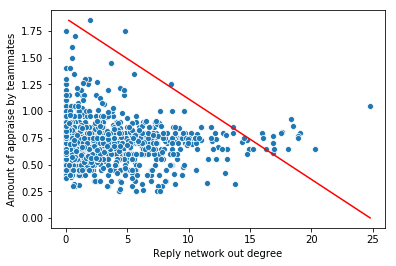


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5469  , p=0.0021  , df_denom=1103, df_num=1
ssr based chi2 test:   chi2=9.5728  , p=0.0020  , df=1
likelihood ratio test: chi2=9.5316  , p=0.0020  , df=1
parameter F test:         F=9.5469  , p=0.0021  , df_denom=1103, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.2719  , p=0.0003  , df_denom=1100, df_num=2
ssr based chi2 test:   chi2=16.6191 , p=0.0002  , df=2
likelihood ratio test: chi2=16.4954 , p=0.0003  , df=2
parameter F test:         F=8.2719  , p=0.0003  , df_denom=1100, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.2367  , p=0.0014  , df_denom=1097, df_num=3
ssr based chi2 test:   chi2=15.8104 , p=0.0012  , df=3
likelihood ratio test: chi2=15.6983 , p=0.0013  , df=3
parameter F test:         F=5.2367  , p=0.0014  , df_denom=1097, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9911  , p=0.

{'causality': {1: ({'lrtest': (9.531627558307719, 0.002019609392239068, 1),
    'params_ftest': (9.546852047078016, 0.002053075460602459, 1103.0, 1),
    'ssr_chi2test': (9.57281809978997, 0.001974794119156541, 1),
    'ssr_ftest': (9.546852047078064, 0.002053075460602459, 1103.0, 1)},
    array([[0., 1., 0.]])]),
  2: ({'lrtest': (16.495351161946473, 0.00026186653799036507, 2),
    'params_ftest': (8.271943625325092, 0.0002718239940090841, 1100.0, 2),
    'ssr_chi2test': (16.61908673815328, 0.00024615642033625455, 2),
    'ssr_ftest': (8.27194362532516, 0.0002718239940090484, 1100.0, 2)},
    array([[0., 0., 1., 0., 0.],
           [0., 0., 0., 1., 0.]])]),
  3: ({'lrtest': (15.69827457981637, 0.0013074791128536941, 3),
    'params_ftest': (5.236722901452187, 0.0013657265813722932, 1097.0, 3),
    'ssr_chi2test': (15.810415906663438, 0.0012401174543686434, 3),
    'ssr_ftest': (5.236722901452232, 0.0013657265813722932, 1097.0, 3)},
    array([[0., 0., 0., 1., 0., 0., 0.],
           [

In [916]:
utils.compute_relationship(
    amount_of_appraise_by_others_vector,
    reply_duration_vector_out,
    'Amount of appraise by teammates',
    'Reply network out degree',
    fname='appraise_vs_replynetworkoutdegree')

r-val: -0.060638413411632223
p-val: 0.04368355084294636 	yay!!!!


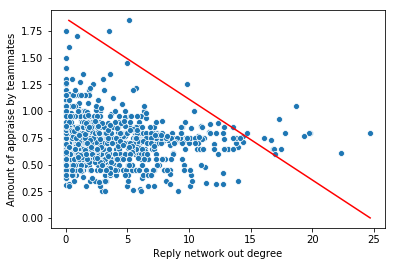


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.5780 , p=0.0002  , df_denom=1103, df_num=1
ssr based chi2 test:   chi2=13.6150 , p=0.0002  , df=1
likelihood ratio test: chi2=13.5318 , p=0.0002  , df=1
parameter F test:         F=13.5780 , p=0.0002  , df_denom=1103, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.4010 , p=0.0000  , df_denom=1100, df_num=2
ssr based chi2 test:   chi2=24.9147 , p=0.0000  , df=2
likelihood ratio test: chi2=24.6380 , p=0.0000  , df=2
parameter F test:         F=12.4010 , p=0.0000  , df_denom=1100, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.5335  , p=0.0001  , df_denom=1097, df_num=3
ssr based chi2 test:   chi2=22.7449 , p=0.0000  , df=3
likelihood ratio test: chi2=22.5137 , p=0.0001  , df=3
parameter F test:         F=7.5335  , p=0.0001  , df_denom=1097, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5048  , p=0.

{'causality': {1: ({'lrtest': (13.531831153949497, 0.00023455108125856717, 1),
    'params_ftest': (13.578020043447982, 0.00023996393297710903, 1103.0, 1),
    'ssr_chi2test': (13.614950288353116, 0.00022439142708495358, 1),
    'ssr_ftest': (13.578020043448, 0.00023996393297710903, 1103.0, 1)},
    array([[0., 1., 0.]])]),
  2: ({'lrtest': (24.637985302887955, 4.4661105487232146e-06, 2),
    'params_ftest': (12.40098814255719, 4.7221299325927204e-06, 1100.0, 2),
    'ssr_chi2test': (24.914712540956, 3.8890086814736405e-06, 2),
    'ssr_ftest': (12.400988142557285, 4.7221299325921165e-06, 1100.0, 2)},
    array([[0., 0., 1., 0., 0.],
           [0., 0., 0., 1., 0.]])]),
  3: ({'lrtest': (22.513726915700772, 5.099336599370843e-05, 3),
    'params_ftest': (7.533546511576457, 5.43401471342068e-05, 1097.0, 3),
    'ssr_chi2test': (22.744855101495745, 4.5642425062528443e-05, 3),
    'ssr_ftest': (7.533546511576339, 5.4340147134218774e-05, 1097.0, 3)},
    array([[0., 0., 0., 1., 0., 0., 0.]

In [917]:
utils.compute_relationship(
    amount_of_appraise_by_others_vector,
    reply_duration_vector_in,
    'Amount of appraise by teammates',
    'Reply network out degree',
    fname='appraise_vs_replynetworkindegree')

r-val: -0.05067291676956666
p-val: 0.10175967801779907 	


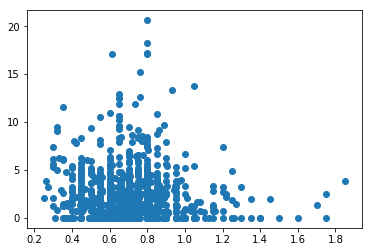


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.2415 , p=0.0003  , df_denom=1040, df_num=1
ssr based chi2 test:   chi2=13.2797 , p=0.0003  , df=1
likelihood ratio test: chi2=13.1959 , p=0.0003  , df=1
parameter F test:         F=13.2415 , p=0.0003  , df_denom=1040, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.3735 , p=0.0000  , df_denom=1037, df_num=2
ssr based chi2 test:   chi2=26.8760 , p=0.0000  , df=2
likelihood ratio test: chi2=26.5353 , p=0.0000  , df=2
parameter F test:         F=13.3735 , p=0.0000  , df_denom=1037, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.8577  , p=0.0000  , df_denom=1034, df_num=3
ssr based chi2 test:   chi2=23.7328 , p=0.0000  , df=3
likelihood ratio test: chi2=23.4663 , p=0.0000  , df=3
parameter F test:         F=7.8577  , p=0.0000  , df_denom=1034, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7701  , p=0.

In [824]:
utils.compute_relationship(
    amount_of_appraise_by_others_vector,
    emotion_dominance_vector_in);

r-val: -0.046931371499657544
p-val: 0.12966671886348013 	


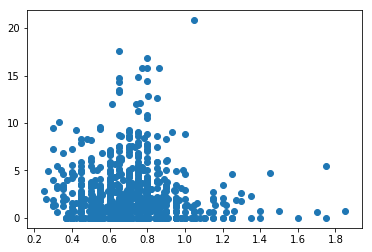


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1529  , p=0.0133  , df_denom=1040, df_num=1
ssr based chi2 test:   chi2=6.1707  , p=0.0130  , df=1
likelihood ratio test: chi2=6.1525  , p=0.0131  , df=1
parameter F test:         F=6.1529  , p=0.0133  , df_denom=1040, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4955  , p=0.0307  , df_denom=1037, df_num=2
ssr based chi2 test:   chi2=7.0246  , p=0.0298  , df=2
likelihood ratio test: chi2=7.0011  , p=0.0302  , df=2
parameter F test:         F=3.4955  , p=0.0307  , df_denom=1037, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4954  , p=0.0585  , df_denom=1034, df_num=3
ssr based chi2 test:   chi2=7.5370  , p=0.0566  , df=3
likelihood ratio test: chi2=7.5098  , p=0.0573  , df=3
parameter F test:         F=2.4954  , p=0.0585  , df_denom=1034, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9017  , p=0.

In [825]:
utils.compute_relationship(
    amount_of_appraise_by_others_vector,
    emotion_dominance_vector_out);

r-val: -0.0488835145684456
p-val: 0.11444475972010759 	


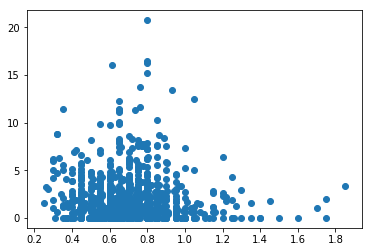


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.5342 , p=0.0004  , df_denom=1040, df_num=1
ssr based chi2 test:   chi2=12.5703 , p=0.0004  , df=1
likelihood ratio test: chi2=12.4952 , p=0.0004  , df=1
parameter F test:         F=12.5342 , p=0.0004  , df_denom=1040, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.5527 , p=0.0000  , df_denom=1037, df_num=2
ssr based chi2 test:   chi2=25.2264 , p=0.0000  , df=2
likelihood ratio test: chi2=24.9259 , p=0.0000  , df=2
parameter F test:         F=12.5527 , p=0.0000  , df_denom=1037, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.2388  , p=0.0001  , df_denom=1034, df_num=3
ssr based chi2 test:   chi2=21.8633 , p=0.0001  , df=3
likelihood ratio test: chi2=21.6369 , p=0.0001  , df=3
parameter F test:         F=7.2388  , p=0.0001  , df_denom=1034, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8400  , p=0.

In [826]:
utils.compute_relationship(
    amount_of_appraise_by_others_vector,
    emotion_arousal_vector_in);

r-val: -0.037586654518933636
p-val: 0.22496322323401882 	


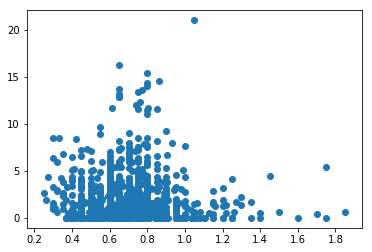


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1393  , p=0.0134  , df_denom=1040, df_num=1
ssr based chi2 test:   chi2=6.1570  , p=0.0131  , df=1
likelihood ratio test: chi2=6.1389  , p=0.0132  , df=1
parameter F test:         F=6.1393  , p=0.0134  , df_denom=1040, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6101  , p=0.0274  , df_denom=1037, df_num=2
ssr based chi2 test:   chi2=7.2550  , p=0.0266  , df=2
likelihood ratio test: chi2=7.2299  , p=0.0269  , df=2
parameter F test:         F=3.6101  , p=0.0274  , df_denom=1037, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3886  , p=0.0674  , df_denom=1034, df_num=3
ssr based chi2 test:   chi2=7.2142  , p=0.0654  , df=3
likelihood ratio test: chi2=7.1894  , p=0.0661  , df=3
parameter F test:         F=2.3886  , p=0.0674  , df_denom=1034, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9090  , p=0.

In [827]:
utils.compute_relationship(
    amount_of_appraise_by_others_vector,
    emotion_arousal_vector_out);

r-val: -0.04998701097701614
p-val: 0.10648317731605458 	


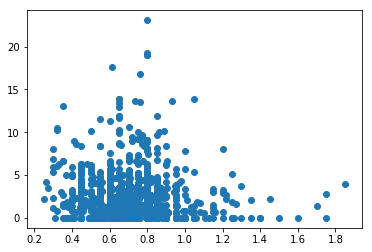


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.0123 , p=0.0003  , df_denom=1040, df_num=1
ssr based chi2 test:   chi2=13.0498 , p=0.0003  , df=1
likelihood ratio test: chi2=12.9689 , p=0.0003  , df=1
parameter F test:         F=13.0123 , p=0.0003  , df_denom=1040, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.4211 , p=0.0000  , df_denom=1037, df_num=2
ssr based chi2 test:   chi2=26.9716 , p=0.0000  , df=2
likelihood ratio test: chi2=26.6284 , p=0.0000  , df=2
parameter F test:         F=13.4211 , p=0.0000  , df_denom=1037, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.7025  , p=0.0000  , df_denom=1034, df_num=3
ssr based chi2 test:   chi2=23.2638 , p=0.0000  , df=3
likelihood ratio test: chi2=23.0077 , p=0.0000  , df=3
parameter F test:         F=7.7025  , p=0.0000  , df_denom=1034, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7060  , p=0.

In [828]:
utils.compute_relationship(
    amount_of_appraise_by_others_vector,
    emotion_valence_vector_in);

r-val: -0.04518903540422089
p-val: 0.14453796064916874 	


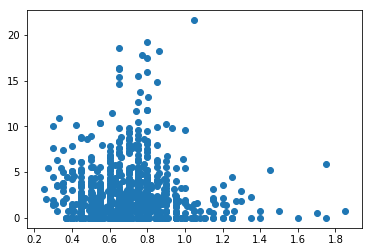


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9089  , p=0.0152  , df_denom=1040, df_num=1
ssr based chi2 test:   chi2=5.9260  , p=0.0149  , df=1
likelihood ratio test: chi2=5.9092  , p=0.0151  , df=1
parameter F test:         F=5.9089  , p=0.0152  , df_denom=1040, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3148  , p=0.0367  , df_denom=1037, df_num=2
ssr based chi2 test:   chi2=6.6615  , p=0.0358  , df=2
likelihood ratio test: chi2=6.6403  , p=0.0361  , df=2
parameter F test:         F=3.3148  , p=0.0367  , df_denom=1037, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3754  , p=0.0686  , df_denom=1034, df_num=3
ssr based chi2 test:   chi2=7.1743  , p=0.0665  , df=3
likelihood ratio test: chi2=7.1497  , p=0.0673  , df=3
parameter F test:         F=2.3754  , p=0.0686  , df_denom=1034, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9436  , p=0.

In [829]:
utils.compute_relationship(
    amount_of_appraise_by_others_vector,
    emotion_valence_vector_out);

r-val: -0.028187054153867616
p-val: 0.36290620636018434 	


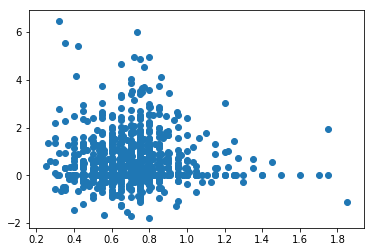


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6467  , p=0.0565  , df_denom=1040, df_num=1
ssr based chi2 test:   chi2=3.6572  , p=0.0558  , df=1
likelihood ratio test: chi2=3.6508  , p=0.0560  , df=1
parameter F test:         F=3.6467  , p=0.0565  , df_denom=1040, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8980  , p=0.1504  , df_denom=1037, df_num=2
ssr based chi2 test:   chi2=3.8144  , p=0.1485  , df=2
likelihood ratio test: chi2=3.8074  , p=0.1490  , df=2
parameter F test:         F=1.8980  , p=0.1504  , df_denom=1037, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9788  , p=0.1155  , df_denom=1034, df_num=3
ssr based chi2 test:   chi2=5.9766  , p=0.1128  , df=3
likelihood ratio test: chi2=5.9595  , p=0.1136  , df=3
parameter F test:         F=1.9788  , p=0.1155  , df_denom=1034, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9236  , p=0.

In [830]:
utils.compute_relationship(
    amount_of_appraise_by_others_vector,
    sentiment_vector_in);

r-val: -0.04080550731084484
p-val: 0.18769268122826843 	


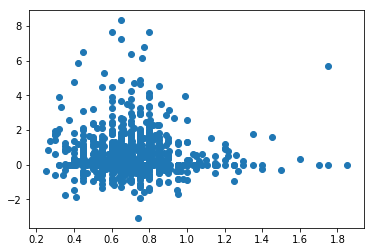


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5328  , p=0.0188  , df_denom=1040, df_num=1
ssr based chi2 test:   chi2=5.5488  , p=0.0185  , df=1
likelihood ratio test: chi2=5.5341  , p=0.0186  , df=1
parameter F test:         F=5.5328  , p=0.0188  , df_denom=1040, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3081  , p=0.0051  , df_denom=1037, df_num=2
ssr based chi2 test:   chi2=10.6673 , p=0.0048  , df=2
likelihood ratio test: chi2=10.6131 , p=0.0050  , df=2
parameter F test:         F=5.3081  , p=0.0051  , df_denom=1037, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7054  , p=0.0442  , df_denom=1034, df_num=3
ssr based chi2 test:   chi2=8.1712  , p=0.0426  , df=3
likelihood ratio test: chi2=8.1393  , p=0.0432  , df=3
parameter F test:         F=2.7054  , p=0.0442  , df_denom=1034, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2930  , p=0.

In [831]:
utils.compute_relationship(
    amount_of_appraise_by_others_vector,
    sentiment_vector_out);

# How strongly connected are the influence matrices?

In [832]:
cnt = 0
not_strongly_connected_cnt = 0
for team_id, team_log in data.items():
    for index, member_influence in enumerate(team_log.member_influences):
        influence_matrix = np.matrix(member_influence) / 100
#         influence_matrix = utils.make_matrix_row_stochastic(member_influence)
        if len(list(nx.strongly_connected_components(nx.DiGraph(influence_matrix)))) != 1:
            print(team_id, index)
            print(influence_matrix)
            print('\n')
            not_strongly_connected_cnt += 1
        else:
            cnt += 1

28 0
[[1.   0.   0.   0.  ]
 [0.3  0.1  0.4  0.2 ]
 [0.3  0.1  0.3  0.3 ]
 [0.25 0.25 0.25 0.25]]


34 1
[[-0.01  0.3   0.25  0.45]
 [ 0.    0.    0.    0.  ]
 [ 0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.25  0.25]]


38 0
[[1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.3  0.3  0.2  0.2 ]]


42 8
[[1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.2  0.4  0.2  0.2 ]
 [0.3  0.1  0.3  0.3 ]]


43 0
[[1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.2  0.4  0.4  0.  ]
 [0.18 0.16 0.16 0.5 ]]


43 1
[[1.   0.   0.   0.  ]
 [0.4  0.4  0.1  0.1 ]
 [0.2  0.   0.5  0.3 ]
 [0.26 0.27 0.27 0.2 ]]


77 0
[[0.25 0.25 0.25 0.25]
 [0.3  0.2  0.4  0.1 ]
 [0.   0.   1.   0.  ]
 [0.25 0.25 0.25 0.25]]




In [833]:
print('From {} influence matrices reports in the '
      'entire data with {} teams, only {} ({:.2f}%) were '
      'not strongly connected.'.format(
          cnt,
          len(data),
          not_strongly_connected_cnt,
          100 * not_strongly_connected_cnt / cnt))

From 332 influence matrices reports in the entire data with 49 teams, only 7 (2.11%) were not strongly connected.


In [446]:
all_cnt = 0
not_reached_consensus_cnt = 0
for team_id, team_log in data.items():
    not_reached_consensus_cnt += len(np.where(np.array(team_log.groupSubmission.groupAnswer) == 'Consensus Not Reached')[0])
    all_cnt += len(team_log.groupSubmission.groupAnswer)

print('From {} questions in the '
      'entire data with {} teams, only in {} ({:.2f}%)'
      ' teams have not reached consensus.'.format(
          all_cnt,
          len(data),
          not_reached_consensus_cnt,
          100 * not_reached_consensus_cnt / all_cnt))

From 1750 questions in the entire data with 49 teams, only in 145 (8.29%) teams have not reached consensus.


# Dynamics of influence matrices

In [951]:
frob_norm_of_consecutive = defaultdict(list)
for team_id, team_log in data.items():
    for index in range(1, len(team_log.member_influences)):
        diff = np.matrix(team_log.member_influences[index]) / 100 - np.matrix(team_log.member_influences[index - 1]) / 100
        frob_norm_of_consecutive[team_id].append(
            np.linalg.norm(diff, ord=2))
#             (np.square(diff)).mean(axis=None))

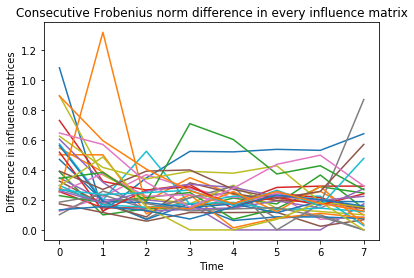

In [952]:
team_diffs = np.zeros(8)
cnt = 0
for team_id, team_diff in frob_norm_of_consecutive.items():
    if len(team_diff) == 8:
        team_diffs += team_diff
        cnt += 1
        plt.plot(team_diff)
team_diffs /= cnt
plt.title('Consecutive Frobenius norm difference in every influence matrix')
plt.xlabel('Time')
plt.ylabel('Difference in influence matrices');

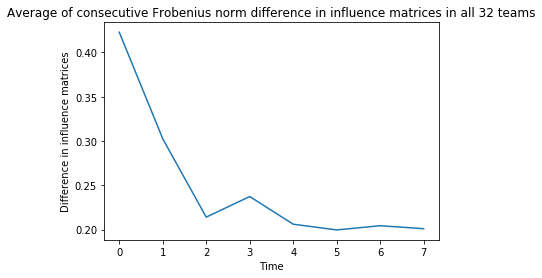

In [953]:
plt.plot(team_diffs);
plt.title('Average of consecutive Frobenius norm difference in influence matrices in all {} teams'.format(cnt))
plt.xlabel('Time')
plt.ylabel('Difference in influence matrices');

#### And its relationship with performance

In [503]:
c = 0
sig_c = 0
for team_id, team_log in data.items():
    if team_id in frob_norm_of_consecutive and 45 in team_log.accumulated_score:
        c += 1
        this_team_diff = frob_norm_of_consecutive[team_id]
        this_team_perf = [team_log.accumulated_score[index] for index in [10, 15, 20, 25, 30, 35, 40, 45]]
        r_val, p_val = sp.stats.pearsonr(this_team_diff, this_team_perf)
        if p_val < 0.05:
            print(r_val, p_val)
            sig_c += 1
#         utils.compute_relationship(this_team_diff, this_team_perf, maxlag=1)

-0.7680855906773422 0.02601105129486113
-0.7135011778509429 0.046881934464170175
-0.7290727743407934 0.04016148582204802
-0.722060360320318 0.043110083288295804
-0.7173505678181669 0.045161927009208735
-0.7594052826922197 0.02883718158099217
-0.7873209221948606 0.02037694101689579
-0.7217222048396326 0.043255481271374005
-0.7462265759731526 0.03347629015421849
-0.9354677888207427 0.0006397487651953237


In [497]:
print('Only {:.2f}% were statistically significant.'.format(100 * sig_c / c))

Only 32.26% were statistically significant.
